# Multi-class image classification - Traffic Sign Classification

Dataset: German Traffic Sign Dataset (http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) <br>
It contains 43 classes of images of different traffic signs. Images vary in size. <br> <br>
Training set size: 39209 <br>
Test set size: 12630 <br>

### 1. Importing libraries

In [21]:
import os
import requests
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 2. Defining global variables

In [75]:
TRAIN_DIR = "./data/GTSRB/Final_Training/Images"
TEST_DIR = "./data/GTSRB/Final_Test/Images"
TEST_GT_DIR = "./data/GT-final_test.csv"
DATA_DIR = "./data"
TRAIN_DOWNLOAD_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
TEST_DOWNLOAD_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip"
TEST_GT_DOWNLOAD_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip"
BATCH_SIZE = 32
VAL_SPLIT = 0.2

### 3. Downloading the data

It might take around 5 minutes to download the data.

In [16]:
def download_and_unzip(download_url, data_dir=DATA_DIR):
    '''Downloads and unzips the data from the given url.
    Args:
        data_dir: The directory where the data should be saved.
        download_url: The url from where the data should be downloaded.
    '''

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    print(f"Starting download from {download_url}")
    response_train = requests.get(download_url)

    if response_train.status_code == 200:
        zip_file_path = os.path.join(data_dir, "file.zip")
        with open(zip_file_path, "wb") as f:
            f.write(response_train.content)
        print(f"Download succesful. Saved to {data_dir}")

        with zipfile.ZipFile(zip_file_path, "r") as zip_f:
            zip_f.extractall(data_dir)
        
        os.remove(zip_file_path)
    else:
        print(f"Download unsuccesful. Status code: {response_train.status_code}")


In [15]:
download_and_unzip(TEST_DOWNLOAD_URL)
download_and_unzip(TRAIN_DOWNLOAD_URL)
download_and_unzip(TEST_GT_DOWNLOAD_URL)

Starting download from https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Download succesful. Saved to ./data
Starting download from https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Download succesful. Saved to ./data
Starting download from https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
Download succesful. Saved to ./data


### 4. Preparing the data

Trainign data is structured in folders, each folder representing a class. <br>
Test data is in a single folder with no class labels. <br>

#### Preparing training data:
We will use `ImageDataGenerator` from `Keras.preprocessing`. <br>
First we rescale images to 0-1 range. <br>
Then we split the training data into training and validation sets. <br>
With help of `flow_from_directory` method we will create batches of images. <br>
Each image is resized to 32x32. <br>
We use batch size of `BATCH_SIZE`. <br>
We will use mode "categorical", since we have more than 2 classes. <br>


#### Preparing test data:
Since there are no class labels in the test data, we will use the `GT-final_test.csv` file to get the class labels. <br>
We will create dataframe containing the file names and class labels. <br>
Then we will use `ImageDataGenerator` rescale the images to 0-1 range. <br>
We will use `flow_from_dataframe` method to create batches of images. <br>
The rest is the same as for training data. <br>


In [78]:
def train_val_tf_dataset(train_dir=TRAIN_DIR, val_split=VAL_SPLIT, batch_size=BATCH_SIZE):
    """
    Returns a train and validation dataset from the given directory.
    Args:
        train_dir: The directory where the training data is located.
        val_split: The validation split of the dataset.
        batch_size: The batch size of the dataset.
    Returns:
        A train and validation dataset.
    """

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=val_split)
    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode="categorical",
        subset="training"
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation"
    )

    return train_generator, validation_generator

def test_tf_dataset(test_dir=TEST_DIR, labels_dir=TEST_GT_DIR, batch_size=BATCH_SIZE):
    """
    Returns a test dataset from the given directory.
    Args:
        test_dir: The directory where the test data is located.
        labels_dir: The directory where the labels of the test data is located.
        batch_size: The batch size of the dataset.
        
    Returns:
        A test dataset.
    """

    with open(labels_dir) as f:
        lines = f.readlines()[1:]
        test_file_names = [line.split(";")[0] for line in lines]
        test_labels = [str(line.split(";")[7]) for line in lines]

    test_df = pd.DataFrame({"Filename": test_file_names, "ClassId": test_labels})

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_dir,
        x_col="Filename",
        y_col="ClassId",
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    return test_generator
    

In [79]:
train_generator, validation_generator = train_val_tf_dataset()
test_generator = test_tf_dataset()

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


# 5. Visualizing the data

We will visualize the first 25 images from the training set. <br>
To do that we will use `imshow` from `matplotlib.pyplot`. <br>

In [67]:
def plot_images(generator, n_images=9):
    """
    Plots n_images from the given generator.
    Args:
        generator: The generator from which the images should be plotted.
        n_images: The number of images to plot.
    """
    
    x, y = generator.next()
    n = np.ceil(np.sqrt(n_images)).astype(np.int32)
    for i in range(0, n_images):
        image = x[i]
        label = np.argmax(y[i])
        plt.subplot(n, n, 1 + i)
        plt.title(label)
        plt.axis("off")
        plt.subplots_adjust(hspace=0.5)
        plt.imshow(image)
    plt.show()

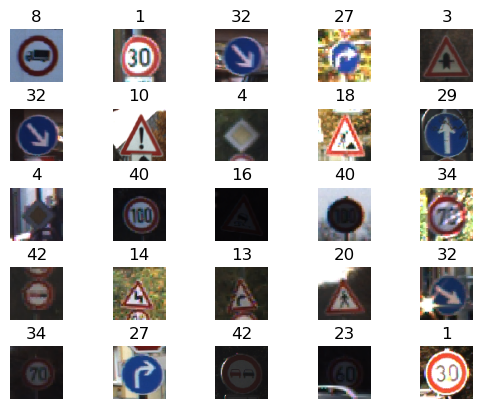

In [80]:
plot_images(test_generator, 25)